# 1D noiseless illustrative example


In [1]:
# import standard libraries
from mfpml.problems.multifidelity_functions import Forrester_1b, mf_Booth
from mfbml.methods.mf_rbf_gpr import MFRBFGPR
from mfbml.methods.rbf_regressor import RBFKernelRegression
from mfbml.metrics.accuracy_metrics import normalized_mae, normalized_rmse, mean_log_likelihood_value
from sklearn.metrics import r2_score
from mfpml.models.scale_kriging import ScaledKriging
from mfpml.models.hierarchical_kriging import HierarchicalKriging
from mfpml.models.co_kriging import CoKriging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import warnings

warnings.filterwarnings("ignore")

In [2]:
# fix the random seed for reproducibility
seed_number = 1996
np.random.seed(seed_number)

## Get function and design of experiment


In [3]:
func = Forrester_1b()
# replace the high fidelity sample with linspace
sample_hx = np.linspace(0, 1, 7).reshape(-1, 1)
sample_lx = np.linspace(0, 1, 200).reshape(-1, 1)
#
sample_x = [sample_hx, sample_lx]

sample_y = func(sample_x)
# add noise to the samples
sample_y[0] += np.random.normal(0, 0.3, sample_y[0].shape)
sample_y[1] += np.random.normal(0, 0.3, sample_y[1].shape)
# generate test samples
test_x = np.linspace(0, 1, 1000).reshape(-1, 1)
test_hy = func.hf(test_x)
test_ly = func.lf(test_x)

# test data noise)
test_hy_noise = test_hy + np.random.normal(0, 0.3, test_hy.shape)
test_ly_noise = test_hy + np.random.normal(0, 0.3, test_ly.shape)

### MF-KRR-GPR


In [4]:
mf_krr_gpr = MFRBFGPR(
    design_space=func._input_domain,
    optimizer_restart=10,
    seed=seed_number,
)
mf_krr_gpr.lf_model = RBFKernelRegression(design_space=func._input_domain,
                                          optimizer_restart=10,
                                          noise_data=True,
                                          seed=seed_number)
mf_krr_gpr.train(samples=sample_x, responses=sample_y)
pred_y, pred_std = mf_krr_gpr.predict(X=test_x, return_std=True)
# get prediction of low fidelity
pred_ly = mf_krr_gpr.predict_lf(X=test_x)
# calculate accuracy metrics
nrmse_mf_rbf_kriging = normalized_rmse(test_hy, pred_y)
nmae_mf_rbf_kriging = normalized_mae(test_hy, pred_y)
r2_mf_rbf_kriging = r2_score(test_hy, pred_y)
mean_ll_mf_krr_gpr = mean_log_likelihood_value(test_hy_noise, pred_y, pred_std)
mf_krr_gpr_lf_training_time = mf_krr_gpr.lf_training_time
mf_krr_gpr_hf_training_time = mf_krr_gpr.hf_training_time
print("nrmse: ", nrmse_mf_rbf_kriging)
print("nmae: ", nmae_mf_rbf_kriging)
print("r2: ", r2_mf_rbf_kriging)
print("mean_ll", mean_ll_mf_krr_gpr)
print("lf time", mf_krr_gpr_lf_training_time)
print("hf time", mf_krr_gpr_hf_training_time)
print("noise", mf_krr_gpr.noise)

nrmse:  0.12321368570910776
nmae:  0.3075505614152858
r2:  0.9948814050589488
mean_ll -0.6675958962801142
lf time 3.5073482990264893
hf time 0.19864177703857422
noise 0.4440045011635387


## HK method


In [5]:

hk_model = HierarchicalKriging(design_space=func._input_domain,
                               optimizer_restart=10,
                               noise_prior=None)
hk_model.train(samples=sample_x, responses=sample_y)
# get prediction of low fidelity
hk_pred_ly = hk_model.predict_lf(X=test_x)
# get prediction of high fidelity
hk_pred_hy, hk_pred_std = hk_model.predict(X=test_x, return_std=True)
end_time = time.time()
# calculate accuracy metrics
nrmse_hk = normalized_rmse(test_hy, hk_pred_hy)
nmae_hk = normalized_mae(test_hy, hk_pred_hy)
r2_hk = r2_score(test_hy, hk_pred_hy)
mean_ll_hk = mean_log_likelihood_value(test_hy_noise, hk_pred_hy, hk_pred_std)
hk_lf_training_time = hk_model.lf_training_time
hk_hf_training_time = hk_model.hf_training_time
hk_noise = hk_model.noise
# print accuracy metrics
print("normalized rmse: ", nrmse_hk)
print("normalized mae: ", nmae_hk)
print("r2: ", r2_hk)
print("lf time", hk_lf_training_time)
print("hf time", hk_hf_training_time)
print("hk noise", hk_noise)

normalized rmse:  0.0912788841880716
normalized mae:  0.16816939399718658
r2:  0.9971908591810935
lf time 4.64838981628418
hf time 0.20152926445007324
hk noise 0.361080572071031


In [6]:
# co-kriging
ck_model = CoKriging(design_space=func._input_domain,
                     noise_prior=None, optimizer_restart=10)
ck_model.train(samples=sample_x, responses=sample_y)
# get prediction of low fidelity
ck_pred_ly = ck_model.predict_lf(X=test_x)
# get prediction of high fidelity
ck_pred_hy, ck_pred_std = ck_model.predict(X=test_x, return_std=True)
end_time = time.time()

# calculate accuracy metrics
nrmse_ck = normalized_rmse(test_hy, ck_pred_hy)
nmae_ck = normalized_mae(test_hy, ck_pred_hy)
r2_ck = r2_score(test_hy, ck_pred_hy)
mean_ll_ck = mean_log_likelihood_value(test_hy_noise, ck_pred_hy, ck_pred_std)
ck_lf_training_time = ck_model.lf_training_time
ck_hf_training_time = ck_model.hf_training_time
ck_noise = ck_model.noise


# print accuracy metrics
print("normalized rmse: ", nrmse_ck)
print("normalized mae: ", nmae_ck)
print("r2: ", r2_ck)
print("lf time", ck_lf_training_time)
print("hf time", ck_hf_training_time)
print("ck noise", ck_noise)

normalized rmse:  0.08623791426113797
normalized mae:  0.154326255127313
r2:  0.9974925669050577
lf time 8.087910175323486
hf time 0.32572412490844727
ck noise 0.35050539179474277


In [7]:
# scaled kriging
sk_model = ScaledKriging(design_space=func._input_domain, optimizer_restart=10)
sk_model.train(samples=sample_x, responses=sample_y)
# get prediction of low fidelity
sk_pred_ly = sk_model.predict_lf(X=test_x)
# get prediction of high fidelity
sk_pred_hy, sk_pred_std = sk_model.predict(X=test_x, return_std=True)

# calculate accuracy metrics
nrmse_sk = normalized_rmse(test_hy, sk_pred_hy)
nmae_sk = normalized_mae(test_hy, sk_pred_hy)
r2_sk = r2_score(test_hy, sk_pred_hy)
mean_ll_sk = mean_log_likelihood_value(test_hy_noise, sk_pred_hy, sk_pred_std)
sk_lf_training_time = sk_model.lf_training_time
sk_hf_training_time = sk_model.hf_training_time
sk_noise = sk_model.noise

# print accuracy metrics
print("normalized mse: ", nrmse_sk)
print("normalized mae: ", nmae_sk)
print("r2: ", r2_sk)
print("mean ll", mean_ll_sk)
print("lf inference time", sk_model.lf_training_time)
print("hf inference time", sk_model.hf_training_time)
print("noise", sk_noise)

normalized mse:  0.21627612287526202
normalized mae:  0.471256422629034
r2:  0.9842293346456314
mean ll -1.4959650057766294
lf inference time 5.8713459968566895
hf inference time 0.2847278118133545
noise 1.1988581548118162


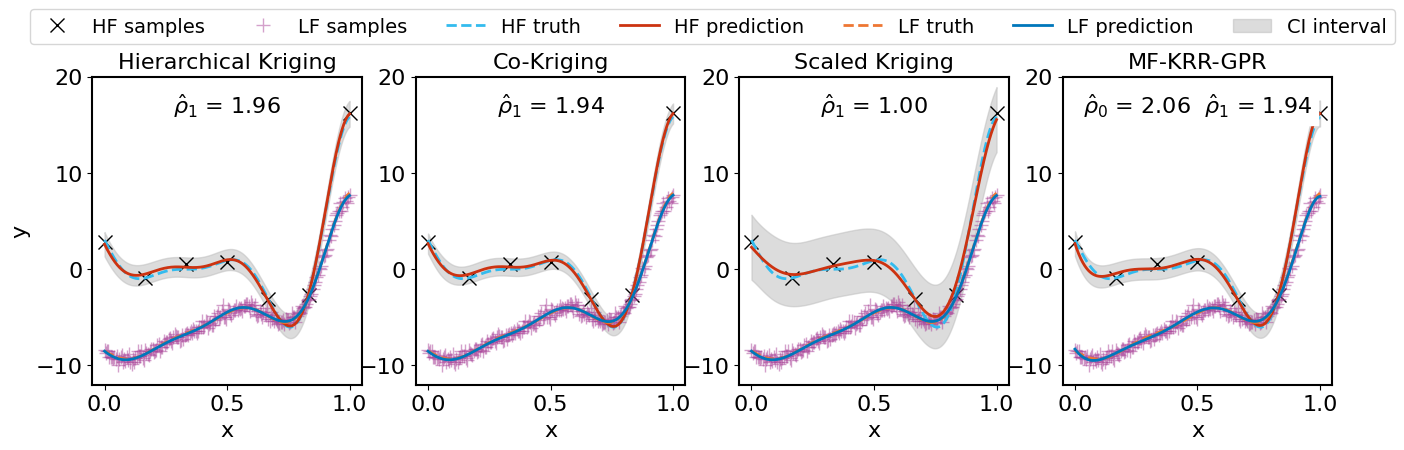

In [10]:
# plot results in 2x2 grid
font_size = 16
# plt.rcParams["text.usetex"] = True
fig, ax = plt.subplots(1, 4, figsize=(16, 4))
ax[3].plot(
    sample_x[0],
    sample_y[0],
    "kx",
    linewidth=2,
    markersize=10,
    label="HF samples",
)
ax[3].plot(
    sample_x[1],
    sample_y[1],
    "+",
    color="#AA4499",
    linewidth=2,
    markersize=10,
    alpha=0.5,
    label="LF samples",
)
ax[3].plot(test_x, test_hy, "--", color="#33BBEE",
           linewidth=2, label="HF truth")
ax[3].plot(test_x, pred_y, "-", color="#CC3311",
           linewidth=2, label="HF prediction")
ax[3].plot(test_x, test_ly, "--", color="#EE7733",
           linewidth=2, label="LF truth")
ax[3].plot(test_x, pred_ly, "-", color="#0077BB",
           linewidth=2, label="LF prediction")

ax[3].fill_between(
    test_x.flatten(),
    (pred_y - 2 * pred_std).flatten(),
    (pred_y + 2 * pred_std).flatten(),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",
)
ax[3].set_title("MF-KRR-GPR", fontsize=font_size)
ax[3].set_ylabel(" ", fontsize=font_size)
ax[3].set_xlabel("x", fontsize=font_size)
ax[3].set_ylim(-12, 20)
ax[3].legend()
# for hierarchical kriging
ax[0].plot(
    sample_x[0],
    sample_y[0],
    "kx",
    linewidth=2,
    markersize=10,
    label="HF samples",
)
ax[0].plot(
    sample_x[1],
    sample_y[1],
    "+",
    color="#AA4499",
    linewidth=2,
    markersize=10,
    alpha=0.5,
    label="LF samples",
)
ax[0].plot(test_x, test_hy, "--", color="#33BBEE",
           linewidth=2, label="HF truth")
ax[0].plot(test_x, hk_pred_hy, "-", color="#CC3311",
           linewidth=2, label="HF prediction")
ax[0].plot(test_x, test_ly, "--", color="#EE7733",
           linewidth=2, label="LF truth")
ax[0].plot(test_x, hk_pred_ly, "-", color="#0077BB",
           linewidth=2, label="LF prediction")

ax[0].fill_between(
    test_x.flatten(),
    (hk_pred_hy - 2 * hk_pred_std).flatten(),
    (hk_pred_hy + 2 * hk_pred_std).flatten(),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",
)
ax[0].set_title("Hierarchical Kriging", fontsize=font_size)
ax[0].set_ylabel("y", fontsize=font_size)
ax[0].set_xlabel("x", fontsize=font_size)
ax[0].set_ylim(-12, 20)
# for co-kriging
ax[1].plot(
    sample_x[0],
    sample_y[0],
    "kx",
    linewidth=2,
    markersize=10,
    label="HF samples",
)
ax[1].plot(
    sample_x[1],
    sample_y[1],
    "+",
    color="#AA4499",
    linewidth=2,
    markersize=10,
    alpha=0.5,
    label="LF samples",
)
ax[1].plot(test_x, test_hy, "--", color="#33BBEE",
           linewidth=2, label="HF truth")
ax[1].plot(test_x, ck_pred_hy, "-", color="#CC3311",
           linewidth=2, label="HF prediction")
ax[1].plot(test_x, test_ly, "--", color="#EE7733",
           linewidth=2, label="LF truth")
ax[1].plot(test_x, ck_pred_ly, "-", color="#0077BB",
           linewidth=2, label="LF prediction")

ax[1].fill_between(
    test_x.flatten(),
    (ck_pred_hy - 2 * ck_pred_std).flatten(),
    (ck_pred_hy + 2 * ck_pred_std).flatten(),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",
)
ax[1].set_title("Co-Kriging", fontsize=font_size)
ax[1].set_ylabel(" ", fontsize=font_size)
ax[1].set_xlabel("x", fontsize=font_size)
ax[1].set_ylim(-12, 20)
# for scaled kriging
ax[2].plot(
    sample_x[0],
    sample_y[0],
    "kx",
    linewidth=2,
    markersize=10,
    label="HF samples",
)
ax[2].plot(
    sample_x[1],
    sample_y[1],
    "+",
    color="#AA4499",
    linewidth=2,
    markersize=10,
    alpha=0.5,
    label="LF samples",
)
ax[2].plot(test_x, test_hy, "--", color="#33BBEE",
           linewidth=2, label="HF truth")
ax[2].plot(test_x, sk_pred_hy, "-", color="#CC3311",
           linewidth=2, label="HF prediction")
ax[2].plot(test_x, test_ly, "--", color="#EE7733",
           linewidth=2, label="LF truth")
ax[2].plot(test_x, sk_pred_ly, "-", color="#0077BB",
           linewidth=2, label="LF prediction")

ax[2].fill_between(
    test_x.flatten(),
    (sk_pred_hy - 2 * sk_pred_std).flatten(),
    (sk_pred_hy + 2 * sk_pred_std).flatten(),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",
)
ax[2].set_ylim(-12, 20)
# write text on the plot of beta0= 0.5  and beta0= 0.5 on the middle top of the plot
ax[0].text(
    0.5,
    17.0,
    r"$\hat \rho_1$ = {:.2f}".format(
        hk_model.beta[0, 0],
    ),
    fontsize=font_size,
    ha="center",
    va="center",
    backgroundcolor="white",
)
ax[1].text(
    0.5,
    17.0,
    r"$\hat \rho_1$ = {:.2f}".format(
        ck_model.rho,
    ),
    fontsize=font_size,
    ha="center",
    va="center",
    backgroundcolor="white",
)
ax[2].text(
    0.5,
    17.0,
    r"$\hat \rho_1$ = {:.2f}".format(
        1.0,
    ),
    fontsize=font_size,
    ha="center",
    va="center",
    backgroundcolor="white",
)
# two numbers on the middle top of the plot for mf-rbf-kriging on two lines
ax[3].text(
    0.5,
    17.0,
    r"$\hat \rho_0$ = {:.2f}  $\hat \rho_1$ = {:.2f}".format(
        mf_krr_gpr.beta[0, 0], mf_krr_gpr.beta[1, 0]
    ),
    fontsize=font_size,
    ha="center",
    va="center",
    backgroundcolor="white",
)

ax[2].set_title("Scaled Kriging", fontsize=font_size)
ax[2].set_ylabel(" ", fontsize=font_size)
ax[2].set_xlabel("x", fontsize=font_size)


plt.legend(loc="upper center", bbox_to_anchor=(-1.30, 1.25),
           ncol=7, fontsize=14)
# set the font size of axis
for i in range(4):
    ax[i].tick_params(axis="both", which="major", labelsize=font_size)
    # set the line width of the axis
    for axis in ["top", "bottom", "left", "right"]:
        ax[i].spines[axis].set_linewidth(1.5)
plt.savefig("mf_rbf_gpr_noisy_1d.pdf", bbox_inches="tight", dpi=300)
plt.savefig("mf_rbf_gpr_noisy_1d.png", bbox_inches="tight", dpi=300)
plt.savefig("mf_rbf_gpr_noisy_1d.svg", bbox_inches="tight", dpi=300)
plt.show()

In [9]:
# save the results into a pandas dataframe
df = pd.DataFrame(columns=["nrmse", "nmae", "r2",
                  "lf_training_time", "hf_training_time", "noise", "mean ll"])
df.loc["hierarchical_kriging"] = [nrmse_hk, nmae_hk, r2_hk,
                                  hk_lf_training_time, hk_hf_training_time, hk_noise, mean_ll_hk]
df.loc["co_kriging"] = [nrmse_ck, nmae_ck, r2_ck,
                        ck_lf_training_time, ck_hf_training_time, ck_noise, mean_ll_ck]
df.loc["scaled_kriging"] = [nrmse_sk, nmae_sk, r2_sk,
                            sk_lf_training_time, sk_hf_training_time, sk_noise, mean_ll_sk]
df.loc["mf_rbf_kriging"] = [
    nrmse_mf_rbf_kriging,
    nmae_mf_rbf_kriging,
    r2_mf_rbf_kriging,
    mf_krr_gpr_lf_training_time,
    mf_krr_gpr_hf_training_time,
    mf_krr_gpr.noise,
    mean_ll_mf_krr_gpr
]
# save the results into a csv file
df.to_csv("result_of_illustrative_example.csv")

# print the results
print(df)

                         nrmse      nmae        r2  lf_training_time  \
hierarchical_kriging  0.091279  0.168169  0.997191          4.648390   
co_kriging            0.086238  0.154326  0.997493          8.087910   
scaled_kriging        0.216276  0.471256  0.984229          5.871346   
mf_rbf_kriging        0.123214  0.307551  0.994881          3.507348   

                      hf_training_time     noise   mean ll  
hierarchical_kriging          0.201529  0.361081 -0.577158  
co_kriging                    0.325724  0.350505 -0.499129  
scaled_kriging                0.284728  1.198858 -1.495965  
mf_rbf_kriging                0.198642  0.444005 -0.667596  
